In [1]:
from DataLoading import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_loader = DataLoader("config.share")
df = data_loader.load_table(device_id="1a9da8fa-6fa8-49f3-8aaa-420b34eefe57", year_month=[
    "202101", "202102","202103", "202104", "202105", "202106", "202107", "202108", "202109", "202110", "202111", "202112"])

25/03/20 14:51:25 WARN Utils: Your hostname, MacBook-Pro-von-Henri.local resolves to a loopback address: 127.0.0.1; using 10.51.3.132 instead (on interface en0)
25/03/20 14:51:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/henribreuer/anaconda3/envs/start-belimo/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/henribreuer/.ivy2/cache
The jars for the packages stored in: /Users/henribreuer/.ivy2/jars
io.delta#delta-sharing-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5714896b-623f-43a5-9467-3a0c4553df80;1.0
	confs: [default]
	found io.delta#delta-sharing-spark_2.12;3.3.0 in central
	found io.delta#delta-spark_2.12;3.3.0 in central
	found io.delta#delta-storage;3.3.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found io.delta#delta-sharing-client_2.12;1.2.2 in central
	found org.apache.httpcomponents#httpclient;4.5.14 in central
	found org.apache.httpcomponents#httpcore;4.4.16 in central
	found commons-logging#commons-logging;1.2 in local-m2-cache
	found commons-codec#commons-codec;1.11 in local-m2-cache
:: resolution report :: resolve 664ms :: artifacts dl 62ms
	:: modules in use:
	commons-codec#commons-codec;1.11 from local-m2-cache in [default]
	commons-logging#commons-logging;1.2 from loc

In [2]:
# sort df by sample time
df = df.sort_values("sample_time")

In [3]:

# Ensure timestamps are in datetime format
df["sample_time"] = pd.to_datetime(df["sample_time"])
df["cloud_received_time"] = pd.to_datetime(df["cloud_received_time"])

# Sort by timestamp
df = df.sort_values(by="sample_time")

# Compute time gaps between consecutive records
df["time_gap_h"] = df["sample_time"].diff().dt.total_seconds() / 3600

# Define threshold for downtime (e.g., gaps > 1 hour indicate a possible downtime)
downtime_threshold = 1
df["downtime_event"] = df["time_gap_h"] > downtime_threshold

downtime_events = df[df["downtime_event"]]

# Compute Uptime Percentage
uptime_hours = df["time_gap_h"].sum()
total_hours = (df["sample_time"].max() - df["sample_time"].min()).total_seconds() / 3600
uptime_percentage = (uptime_hours / total_hours) * 100

# Error Status Analysis
df["Error_Status_Cloud"] = df["Error_Status_Cloud"].fillna(0)  # Replace NaN with 0
df["error_occurrence"] = df["Error_Status_Cloud"] > 0
error_heatmap = df.pivot_table(values="error_occurrence", index=df["sample_time"].dt.date, columns=df["sample_time"].dt.hour, aggfunc="sum")


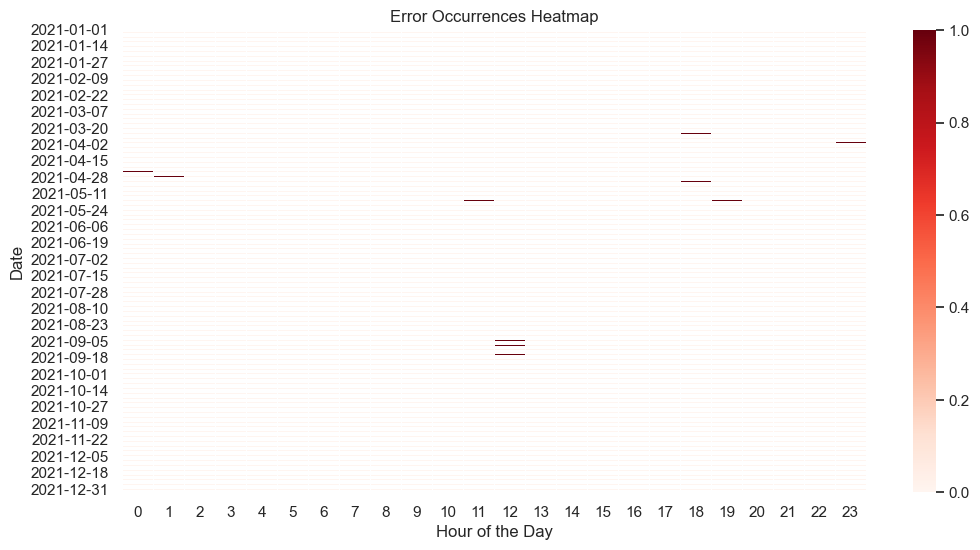

In [13]:
# Plot Error Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(error_heatmap, cmap="Reds", linewidths=0.5, annot=False)
plt.xlabel("Hour of the Day")
plt.ylabel("Date")

plt.title("Error Occurrences Heatmap")
plt.show()

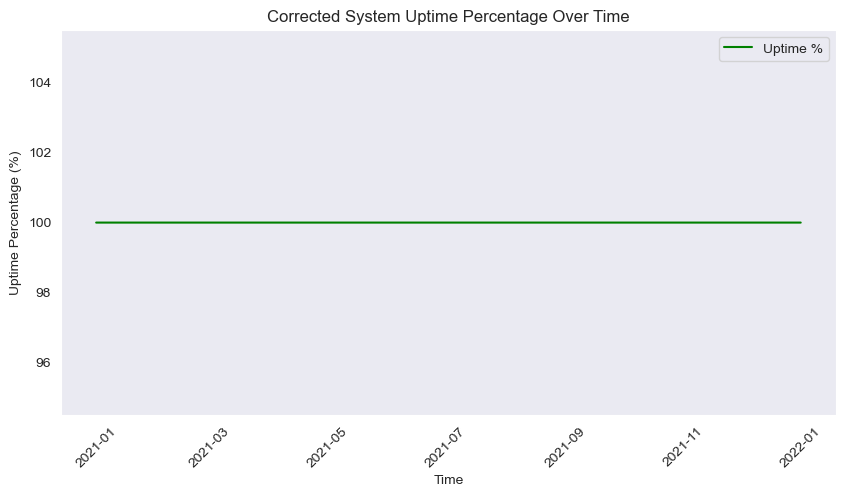

In [6]:
# Ensure sample_time is in datetime format
df["sample_time"] = pd.to_datetime(df["sample_time"])

# Define total possible operational hours (difference between first and last timestamp)
total_observed_hours = (df["sample_time"].max() - df["sample_time"].min()).total_seconds() / 3600

# Compute total recorded operational hours (sum of all valid time gaps)
uptime_hours = df["time_gap_h"].sum()

# Compute correct uptime percentage
df["Uptime_Percentage"] = (uptime_hours / total_observed_hours) * 100

# Plot improved uptime percentage
plt.figure(figsize=(10, 5))
plt.plot(df["sample_time"], df["Uptime_Percentage"], label="Uptime %", color="green")
plt.xlabel("Time")
plt.ylabel("Uptime Percentage (%)")
plt.title("Corrected System Uptime Percentage Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()